## EBITDA - LSTM Model

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
from sklearn.preprocessing import MinMaxScaler

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
current_directory = os.getcwd()
current_directory

'/Users/ruijuewang/Desktop/DFT/Sem2/FT5005 ML for Finance/Group Project/github/FT5005-Group6/Cleaned Data'

In [3]:
processed_df = pd.read_csv('EBITDA_new.csv')
processed_df.head()

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,EBITDA,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,EBITDA_lag1,year,quarter
0,ACAN,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.203545,0.0,0.0,...,50.369,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,NaN,2013,1
1,ACAN,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.203545,0.0,0.0,...,42.617,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,50.369,2013,2
2,ACAN,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203545,0.0,0.0,...,46.147,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,42.617,2013,3
3,ACAN,2013Q4,-0.000933,12.247579,0.0,-0.072407,-0.095729,-0.203541,0.0,0.0,...,67.587,13.978878,-0.729457,9.305890,-1.494308,1.563,3.25,46.147,2013,4
4,ACAN,2014Q1,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203550,0.0,0.0,...,70.192,13.796973,-0.753759,9.321372,-1.579023,1.539,3.25,67.587,2014,1


In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

2025-04-30 09:47:11.032223: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# Select features and target variable
# features exclude: 
features = [col for col in processed_df.columns if col not in [ 'EBITDA', 'ticker', 'companyName','fiscalQuarter']]
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Define train and test sets for scaling
X_train_raw = train_df[features]
y_train_raw = train_df[target].values.reshape(-1, 1)
X_test_raw = test_df[features]
y_test_raw = test_df[target].values.reshape(-1, 1)

# Scale the features and target
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train_raw)
y_train_scaled = scaler_y.fit_transform(y_train_raw)
X_test_scaled = scaler_X.transform(X_test_raw)
y_test_scaled = scaler_y.transform(y_test_raw)

In [6]:
# Convert to supervised learning format
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i+seq_length])
        y_seq.append(y[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [7]:
# Create sequences
seq_length = 10
X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, seq_length)

# Create sequences for test data
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, seq_length)

print(f'X_train shape: {X_train.shape}') 
print(f'y_train shape: {y_train.shape}')

X_train shape: (373, 10, 25)
y_train shape: (373, 1)


In [8]:
import tensorflow.keras.backend as K
import tensorflow as tf

def r2_keras(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

In [9]:
# Build model

import tensorflow as tf
import random

def set_seeds(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seeds(42)

# model = Sequential([
#     LSTM(30, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
#     Dropout(0.2),
#     LSTM(30),
#     Dropout(0.2),
#     Dense(1)
# ])

model = Sequential([
    LSTM(30, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    Dense(1)
]) 

model.compile(optimizer='adam', loss='mse')
# model.compile(optimizer='adam', loss='mse', metrics=[r2_keras])

X_val = X_test.copy()
y_val = y_test.copy()

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=16,
    callbacks=[early_stop],
    verbose=1
)



# history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val))

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.1230 - val_loss: 0.1023
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0687 - val_loss: 0.0803
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0397 - val_loss: 0.0607
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0360 - val_loss: 0.0742
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0254 - val_loss: 0.0547
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0263 - val_loss: 0.0559
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0241 - val_loss: 0.0513
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0265 - val_loss: 0.0515
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0208 - val_loss: 0.0506
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0190 - val_loss: 0.0500
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0171 - val_loss: 0.0501
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

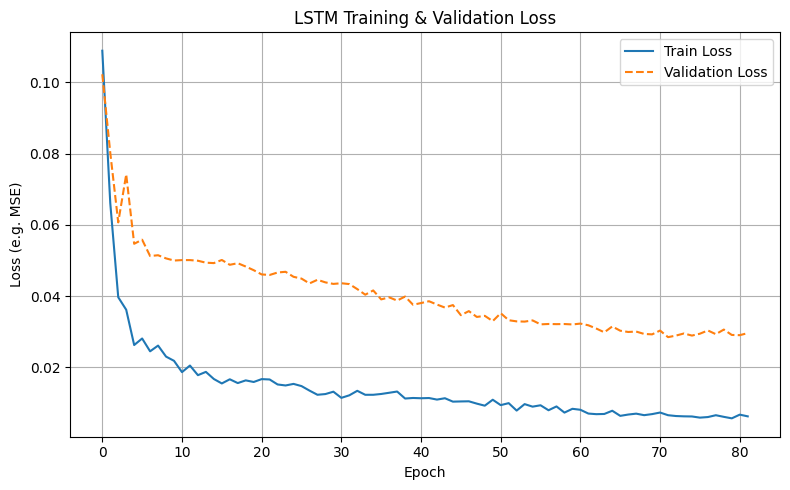

In [10]:
import matplotlib.pyplot as plt

# 画 Loss 曲线
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (e.g. MSE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# plt.figure(figsize=(8, 5))
# plt.plot(history.history['r2_keras'], label='Train R2')
# plt.plot(history.history['val_r2_keras'], label='Validation R2', linestyle='--')
# plt.title('LSTM Training & Validation R2')
# plt.xlabel('Epoch')
# plt.ylabel('R2')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Train MSE: 268.2732
Train R2: 0.9496


Text(0.5, 1.0, 'Train Prediction vs Ground Truth')

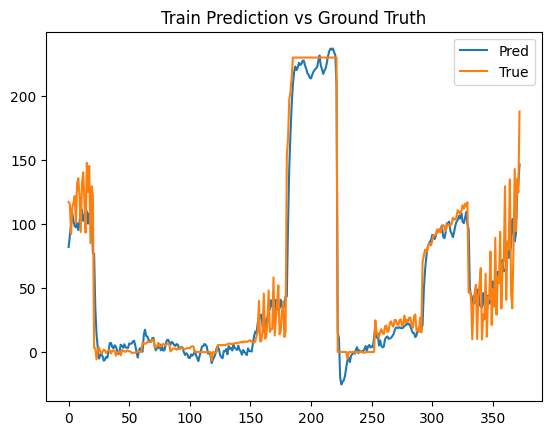

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_train)
y_train_inv = scaler_y.inverse_transform(y_train)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_train_inv, y_pred_inv)
r2 = r2_score(y_train_inv, y_pred_inv)
print(f"Train MSE: {mse:.4f}")
print(f"Train R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_train_inv, label='True')
plt.legend()
plt.title("Train Prediction vs Ground Truth")


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Test MSE: 1592.9705
Test R2: 0.7454


Text(0.5, 1.0, 'Test Prediction vs Ground Truth')

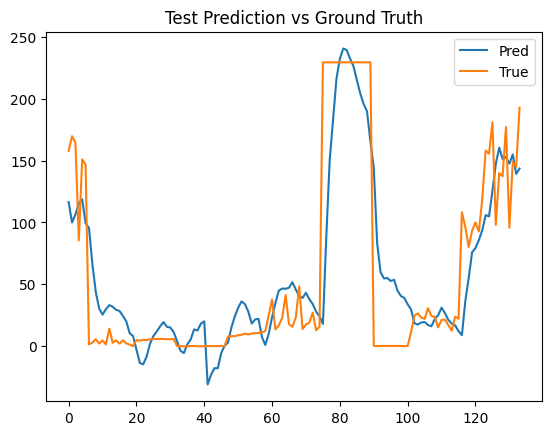

In [12]:
# Predict and evaluate
from sklearn.metrics import mean_squared_error, r2_score

y_pred = model.predict(X_test)
y_test_inv = scaler_y.inverse_transform(y_test)
y_pred_inv = scaler_y.inverse_transform(y_pred)

mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")

plt.plot(y_pred_inv, label='Pred')
plt.plot(y_test_inv, label='True')
plt.legend()
plt.title("Test Prediction vs Ground Truth")

In [13]:
import pickle
import joblib

# Add this where you save your LSTM model and data
def save_lstm_model_and_data(model, scaler_X, scaler_y, X_test_raw, y_test_raw, X_test, y_test, seq_length=10):
    """
    Save the trained LSTM model, scaling information, and test data for later use in stacking
    """
    # Make sure models directory exists
    os.makedirs('models', exist_ok=True)
    
    # Save the LSTM model
    model.save('models/lstm_model.h5')
    
    # Save test indices to track which rows were kept after sequence creation
    test_indices = np.arange(seq_length, len(X_test_raw))
    np.save('models/lstm_test_indices.npy', test_indices)
    
    # Save scaling information
    scaling_info = {
        'scaler_X': scaler_X,
        'scaler_y': scaler_y,
        'seq_length': seq_length
    }
    
    with open('models/lstm_scaling_info.pkl', 'wb') as f:
        pickle.dump(scaling_info, f)
    
    # Save test data - both the raw data and the processed sequences
    joblib.dump([X_test_raw, y_test_raw], 'models/test_data_raw.joblib')
    joblib.dump([X_test, y_test], 'models/test_data.joblib')
    
    # Save predictions for test data
    y_pred = model.predict(X_test)
    y_pred_inv = scaler_y.inverse_transform(y_pred)
    
    # Save predictions
    np.save('models/lstm_test_preds.npy', y_pred_inv.flatten())
    
    print("LSTM model, scaling information, and test predictions saved successfully!")

save_lstm_model_and_data(model, scaler_X, scaler_y, X_test_raw, y_test_raw, X_test, y_test, seq_length=seq_length)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
LSTM model, scaling information, and test predictions saved successfully!


#### Test LSTM

In [14]:
import numpy as np
import pandas as pd
import pickle
import os
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
import joblib

def prepare_lstm_input(X_data, seq_length=10, scaler_X=None):
    """
    Prepare data for LSTM prediction by creating sequences
    
    Args:
        X_data: Input features 
        seq_length: Length of sequences for LSTM
        scaler_X: Scaler for features if needed
    
    Returns:
        X_sequences: Data formatted for LSTM input
    """
    if scaler_X:
        X_scaled = scaler_X.transform(X_data)
    else:
        X_scaled = X_data
    
    # For prediction, we can only use the last seq_length points
    if len(X_scaled) >= seq_length:
        return np.array([X_scaled[-seq_length:]])
    else:
        # Not enough data points, pad with zeros
        padding = np.zeros((seq_length - len(X_scaled), X_scaled.shape[1]))
        padded_data = np.vstack([padding, X_scaled])
        return np.array([padded_data])

def generate_lstm_predictions():
    """
    Generate predictions from the LSTM model with proper reshaping
    """
    # Make sure models directory exists
    os.makedirs('models', exist_ok=True)
    
    # Load LSTM model
    if not os.path.exists('models/lstm_model.h5'):
        print("LSTM model not found")
        return None
    
    lstm_model = load_model('models/lstm_model.h5', compile=False)
    lstm_model.compile(optimizer='adam', loss='mse')

    # Load scaling info
    if not os.path.exists('models/lstm_scaling_info.pkl'):
        print("LSTM scaling info not found")
        return None
    
    with open('models/lstm_scaling_info.pkl', 'rb') as f:
        scaling_info = pickle.load(f)
    
    scaler_X = scaling_info['scaler_X']
    scaler_y = scaling_info['scaler_y']
    seq_length = scaling_info['seq_length']
    
    print(f"LSTM model loaded with sequence length: {seq_length}")
    
    # Load test data
    if not os.path.exists('models/test_data.joblib'):
        print("Test data not found")
        return None
    
    X_test, y_test = joblib.load('models/test_data.joblib')
    
    # Check if existing predictions exist
    if os.path.exists('models/lstm_test_preds.npy'):
        print("LSTM test predictions already exist, loading them...")
        lstm_test_preds = np.load('models/lstm_test_preds.npy')
        
        # Verify shape
        if len(lstm_test_preds) == len(y_test):
            print("Loaded predictions have correct shape")
            
            # Calculate metrics
            y_test_inv = scaler_y.inverse_transform(y_test)
            rmse = np.sqrt(mean_squared_error(y_test_inv, lstm_test_preds))
            r2 = r2_score(y_test_inv, lstm_test_preds)
            print(f"LSTM - RMSE: {rmse:.2f}, R2: {r2:.4f}")
            
            return lstm_test_preds
        else:
            print("Loaded predictions have incorrect shape, regenerating...")
    
    # Generate predictions row by row (for each company)
    all_predictions = []
    
    try:
        # Group by ticker to maintain time-series structure
        if 'ticker' in X_test.columns:
            tickers = X_test['ticker'].unique()
            
            for ticker in tickers:
                ticker_data = X_test[X_test['ticker'] == ticker]
                
                # Apply scaling and reshape for LSTM
                X_ticker_seq = prepare_lstm_input(ticker_data, seq_length, scaler_X)
                
                # Predict
                y_pred_scaled = lstm_model.predict(X_ticker_seq)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)
                
                # Add predictions for this ticker
                all_predictions.extend(y_pred)
                
            lstm_test_preds = np.array(all_predictions).flatten()
        else:
            # If we can't group by ticker, we'll create sliding windows
            lstm_test_preds = np.zeros(len(X_test))
            
            for i in range(len(X_test) - seq_length + 1):
                # Create sequence
                X_seq = X_test.iloc[i:i+seq_length].values
                X_seq_scaled = scaler_X.transform(X_seq)
                X_seq_reshaped = np.array([X_seq_scaled])
                
                # Predict
                y_pred_scaled = lstm_model.predict(X_seq_reshaped)
                y_pred = scaler_y.inverse_transform(y_pred_scaled)[0][0]
                
                # Store prediction
                lstm_test_preds[i+seq_length-1] = y_pred
            
            # For the first seq_length-1 rows, we don't have enough history
            # We'll fill those with the first valid prediction
            first_valid = lstm_test_preds[seq_length-1]
            lstm_test_preds[:seq_length-1] = first_valid
        
        # Save predictions
        np.save('models/lstm_test_preds.npy', lstm_test_preds)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, lstm_test_preds))
        r2 = r2_score(y_test, lstm_test_preds)
        print(f"LSTM - RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        return lstm_test_preds
        
    except Exception as e:
        print(f"Error generating LSTM predictions: {e}")
        return None

if __name__ == "__main__":
    lstm_preds = generate_lstm_predictions()
    
    if lstm_preds is not None:
        print("LSTM predictions generated successfully!")
    else:
        print("Failed to generate LSTM predictions")

LSTM model loaded with sequence length: 10
LSTM test predictions already exist, loading them...
Loaded predictions have correct shape
LSTM - RMSE: 39.91, R2: 0.7454
LSTM predictions generated successfully!


Random Forest
==========

In [15]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [16]:
processed_df = pd.read_csv("EBITDA_new.csv")
processed_df.head(3)

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,EBITDA,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,EBITDA_lag1,year,quarter
0,ACAN,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.203545,0.0,0.0,...,50.369,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,NaN,2013,1
1,ACAN,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.203545,0.0,0.0,...,42.617,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,50.369,2013,2
2,ACAN,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203545,0.0,0.0,...,46.147,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,42.617,2013,3


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Select features and target variable
# features exclude: 
features = [col for col in processed_df.columns if col not in [ 'EBITDA', 'ticker', 'companyName','fiscalQuarter']]
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Update train and test sets
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

Mean Squared Error: 475.18480204598814
R^2 Score: 0.9217680048739663


In [18]:
# Feature importance
feature_importances = rf_model.feature_importances_

# Map feature importances to feature names
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)

                     Feature  Importance
22               EBITDA_lag1    0.927436
0   commonSharesOutstanding_    0.028308
2        capitalExpenditure_    0.005879
14                       mva    0.004161
12             revenueGrowth    0.004019
9          debtToTotalAssets    0.003804
6               totalAssets_    0.003741
5        shareholdersEquity_    0.002462
1        commonSharesTraded_    0.002274
3                 netIncome_    0.001886
7                       EPS_    0.001753
15              ebitdaGrowth    0.001743
20                m2Velocity    0.001369
18                      m2SA    0.001331
19             m2m1GrowthGap    0.001250
17                 realGDPSA    0.001129
16                 salePrice    0.001025
13           netIncomeGrowth    0.000966
4           operatingIncome_    0.000961
10                 niToAsset    0.000916
11                       ROA    0.000885
24                   quarter    0.000880
8           costOfGoodsSold_    0.000814
21              

In [19]:
# Add this code at the end of your RandomForest.ipynb notebook

import pickle
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold

# Create directory for saving models if it doesn't exist
os.makedirs('models', exist_ok=True)

# 1. Save the trained Random Forest model
with open('models/random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

# 2. Save test predictions
np.save('models/random_forest_test_preds.npy', y_pred)

# 3. Generate and save out-of-fold predictions for training data
# This is important for stacking - you need predictions on training data that weren't used to train the model

# Create empty array for OOF predictions
oof_predictions = np.zeros_like(y_train)

# Define k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("Generating out-of-fold predictions for Random Forest...")

# For each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    print(f"Processing fold {fold+1}/5")
    
    # Split data for this fold
    X_fold_train, X_fold_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_fold_train, y_fold_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
    
    # Train model
    from sklearn.ensemble import RandomForestRegressor
    fold_model = RandomForestRegressor(n_estimators=100, random_state=42)
    fold_model.fit(X_fold_train, y_fold_train)
    
    # Generate predictions
    fold_preds = fold_model.predict(X_fold_val)
    
    # Store predictions
    oof_predictions[val_idx] = fold_preds

# Save OOF predictions
np.save('models/random_forest_oof_preds.npy', oof_predictions)

# Also save feature names to ensure consistency
with open('models/feature_names.pkl', 'wb') as f:
    pickle.dump(features, f)

# Calculate and print OOF performance
oof_mse = mean_squared_error(y_train, oof_predictions)
oof_r2 = r2_score(y_train, oof_predictions)

print(f"Out-of-fold Mean Squared Error: {oof_mse}")
print(f"Out-of-fold R^2 Score: {oof_r2}")

print("Random Forest model and predictions saved successfully!")

Generating out-of-fold predictions for Random Forest...
Processing fold 1/5
Processing fold 2/5
Processing fold 3/5
Processing fold 4/5
Processing fold 5/5
Out-of-fold Mean Squared Error: 347.02422185596447
Out-of-fold R^2 Score: 0.9332242011797566
Random Forest model and predictions saved successfully!


# LightGBM

In [20]:
import pandas as pd
import numpy as np
import os
import sys
import argparse
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [21]:
processed_df = pd.read_csv("EBITDA_new.csv")
processed_df.head(3)

,ticker,fiscalQuarter,commonSharesOutstanding_,commonSharesTraded_,capitalExpenditure_,netIncome_,operatingIncome_,shareholdersEquity_,totalAssets_,EPS_,...,EBITDA,salePrice,realGDPSA,m2SA,m2m1GrowthGap,m2Velocity,primeRate,EBITDA_lag1,year,quarter
0,ACAN,2013Q1,-0.000933,12.247579,0.0,-0.073272,-0.095742,-0.203545,0.0,0.0,...,50.369,13.564960,-0.867729,9.261987,0.172473,1.581,3.25,NaN,2013,1
1,ACAN,2013Q2,-0.000933,12.247579,0.0,-0.073210,-0.095754,-0.203545,0.0,0.0,...,42.617,13.651304,-0.849252,9.272702,-0.640550,1.572,3.25,50.369,2013,2
2,ACAN,2013Q3,-0.000933,12.247579,0.0,-0.073519,-0.095692,-0.203545,0.0,0.0,...,46.147,13.650265,-0.790315,9.286502,-0.328302,1.571,3.25,42.617,2013,3


In [22]:
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# Select features and target variable
# features exclude:
features = [col for col in processed_df.columns if col not in [ 'EBITDA', 'fiscalQuarter','ticker', 'companyName']]
target = 'EBITDA'

# Remove missing values
processed_df = processed_df.dropna(subset=features + [target])

# Split the dataset based on year

train_df = processed_df[processed_df['year'] <= 2020]
test_df = processed_df[processed_df['year'] > 2020]

# Update train and test sets
X_train = train_df[features]
y_train = train_df[target]
X_test = test_df[features]
y_test = test_df[target]
# Create LightGBM datasets
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Define parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_leaves': 31,
    'max_depth': -1,
    'verbose': -1
}

# Train the model
lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], num_boost_round=100)

# Make predictions
y_pred = lgb_model.predict(X_test, num_iteration=lgb_model.best_iteration)

# Evaluate the model
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse}")
print(f"R2 Score: {r2}")

RMSE: 447.603598634377
R2 Score: 0.9263088331192654


In [23]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 创建XGBoost模型
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=1000,
    early_stopping_rounds=50,
    verbosity=1
)

# 训练模型
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    # eval_metric='rmse',
    # verbose=100
)

# 预测
y_pred_xgb = xgb_model.predict(X_test)

# 评估模型
rmse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost RMSE: {rmse_xgb}")
print(f"XGBoost R2 Score: {r2_xgb}")

[0]	validation_0-rmse:65.18658	validation_1-rmse:70.69507
[1]	validation_0-rmse:58.96824	validation_1-rmse:64.04250
[2]	validation_0-rmse:53.36518	validation_1-rmse:58.64142
[3]	validation_0-rmse:48.30528	validation_1-rmse:54.15697
[4]	validation_0-rmse:43.72576	validation_1-rmse:49.63504
[5]	validation_0-rmse:39.58620	validation_1-rmse:45.92188
[6]	validation_0-rmse:35.84164	validation_1-rmse:42.94177
[7]	validation_0-rmse:32.46291	validation_1-rmse:40.08295
[8]	validation_0-rmse:29.42852	validation_1-rmse:37.62226
[9]	validation_0-rmse:26.69362	validation_1-rmse:35.37411
[10]	validation_0-rmse:24.22349	validation_1-rmse:33.53141
[11]	validation_0-rmse:22.00641	validation_1-rmse:32.06234
[12]	validation_0-rmse:19.99757	validation_1-rmse:30.79762
[13]	validation_0-rmse:18.18703	validation_1-rmse:29.40714
[14]	validation_0-rmse:16.57578	validation_1-rmse:28.21600
[15]	validation_0-rmse:15.10071	validation_1-rmse:27.21199
[16]	validation_0-rmse:13.78092	validation_1-rmse:26.47725
[17]	va

In [24]:
import os
import pickle
import joblib

# Create a directory to save models if it doesn't exist
os.makedirs('models', exist_ok=True)

# After training your LightGBM model
# Save the LightGBM model using its native method
lgb_model.save_model('models/lightgbm_model.txt')

# Alternatively, save using pickle for consistent API
with open('models/lightgbm_model.pkl', 'wb') as f:
    pickle.dump(lgb_model, f)

# Save the XGBoost model
# XGBoost has multiple ways to save models
xgb_model.save_model('models/xgboost_model.json')  # Native XGBoost format

# Also save as pickle for consistency
with open('models/xgboost_model.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Save the training and testing data for later
joblib.dump([X_train, y_train], 'models/train_data.joblib')
joblib.dump([X_test, y_test], 'models/test_data.joblib')

# If you need to save feature names for reference
with open('models/feature_names.txt', 'w') as f:
    f.write('\n'.join(features))

print("Models and data saved to 'models/' directory")


Models and data saved to 'models/' directory


In [25]:
import os  # For interacting with the operating system
import glob  # For finding file paths matching a pattern
# Define the directory path where Excel files are stored
folder_path = './models'  # Replace with your folder path

# Use glob to list all Excel files in the folder
files = glob.glob(os.path.join(folder_path, '*'))  # Adjust the extension if needed
files

['./models/random_forest_model.pkl',
 './models/lstm_test_preds.npy',
 './models/xgboost_test_preds.npy',
 './models/lightgbm_model.txt',
 './models/stacking_preds.npy',
 './models/random_forest_oof_preds.npy',
 './models/stacking_coefficients.csv',
 './models/test_data.joblib',
 './models/lightgbm_test_preds.npy',
 './models/xgboost_model.json',
 './models/lightgbm_model.pkl',
 './models/lstm_test_indices.npy',
 './models/test_data_raw.joblib',
 './models/feature_names.txt',
 './models/train_data.joblib',
 './models/stacking_model.pkl',
 './models/lstm_model.h5',
 './models/lightgbm_oof_preds.npy',
 './models/xgboost_model.pkl',
 './models/xgboost_oof_preds.npy',
 './models/feature_names.pkl',
 './models/random_forest_test_preds.npy',
 './models/lstm_scaling_info.pkl']

# Stacking

In [26]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import pickle
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import load_model
from xgboost import XGBRegressor
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

def load_existing_models():
    """
    Load all the pre-trained models found in the models directory
    """
    models = {}
    
    # Check for LightGBM model
    if os.path.exists('models/lightgbm_model.pkl'):
        print("Loading LightGBM model...")
        with open('models/lightgbm_model.pkl', 'rb') as f:
            models['lightgbm'] = pickle.load(f)
    
    # Check for XGBoost model
    if os.path.exists('models/xgboost_model.pkl'):
        print("Loading XGBoost model...")
        with open('models/xgboost_model.pkl', 'rb') as f:
            models['xgboost'] = pickle.load(f)
    
    # Check for Random Forest model
    if os.path.exists('models/random_forest_model.pkl'):
        print("Loading Random Forest model...")
        with open('models/random_forest_model.pkl', 'rb') as f:
            models['random_forest'] = pickle.load(f)
    
    # Check for LSTM model
    if os.path.exists('models/lstm_model.h5'):
        print("Loading LSTM model...")
        try:
            # Store LSTM model separately to handle it differently
            lstm_model = load_model('models/lstm_model.h5', compile=False)
            lstm_model.compile(optimizer='adam', loss='mse')
            models['lstm'] = lstm_model
            
            # Load scaling info if it exists
            if os.path.exists('models/lstm_scaling_info.pkl'):
                with open('models/lstm_scaling_info.pkl', 'rb') as f:
                    models['lstm_scaling_info'] = pickle.load(f)
        except Exception as e:
            print(f"Error loading LSTM model: {e}")
    
    print(f"Loaded {len(models)} models")
    return models

def load_data():
    """
    Load the training and testing data
    """
    # Load data if it exists
    if os.path.exists('models/train_data.joblib') and os.path.exists('models/test_data.joblib'):
        X_train, y_train = joblib.load('models/train_data.joblib')
        X_test, y_test = joblib.load('models/test_data.joblib')
        print("Loaded training and testing data from joblib files")
        return X_train, y_train, X_test, y_test
    else:
        # If data doesn't exist in joblib format, try loading from CSV
        try:
            processed_df = pd.read_csv("EBITDA_new.csv")
            
            # Select features and target variable
            if os.path.exists('models/feature_names.txt'):
                with open('models/feature_names.txt', 'r') as f:
                    features = [line.strip() for line in f.readlines()]
            else:
                features = [col for col in processed_df.columns if col not in ['EBITDA', 'fiscalQuarter']]
            
            target = 'EBITDA'
            
            # Remove missing values
            processed_df = processed_df.dropna(subset=features + [target])
            
            # Split the dataset based on year
            train_df = processed_df[processed_df['year'] <= 2020]
            test_df = processed_df[processed_df['year'] > 2020]
            
            # Prepare data
            X_train = train_df[features]
            y_train = train_df[target]
            X_test = test_df[features]
            y_test = test_df[target]
            
            print("Loaded data from CSV file")
            return X_train, y_train, X_test, y_test
        except Exception as e:
            print(f"Error loading data: {e}")
            raise

def load_predictions():
    """
    Load pre-computed out-of-fold and test predictions if they exist
    """
    oof_preds = {}
    test_preds = {}
    
    # Check for LightGBM predictions
    if os.path.exists('models/lightgbm_oof_preds.npy'):
        oof_preds['lightgbm'] = np.load('models/lightgbm_oof_preds.npy')
    if os.path.exists('models/lightgbm_test_preds.npy'):
        test_preds['lightgbm'] = np.load('models/lightgbm_test_preds.npy')
    
    # Check for XGBoost predictions
    if os.path.exists('models/xgboost_oof_preds.npy'):
        oof_preds['xgboost'] = np.load('models/xgboost_oof_preds.npy')
    if os.path.exists('models/xgboost_test_preds.npy'):
        test_preds['xgboost'] = np.load('models/xgboost_test_preds.npy')
    
    # Check for Random Forest predictions
    if os.path.exists('models/random_forest_oof_preds.npy'):
        oof_preds['random_forest'] = np.load('models/random_forest_oof_preds.npy')
    if os.path.exists('models/random_forest_test_preds.npy'):
        test_preds['random_forest'] = np.load('models/random_forest_test_preds.npy')
    
    # Check for LSTM predictions
    if os.path.exists('models/lstm_oof_preds.npy'):
        oof_preds['lstm'] = np.load('models/lstm_oof_preds.npy')
    if os.path.exists('models/lstm_test_preds.npy'):
        test_preds['lstm'] = np.load('models/lstm_test_preds.npy')
    
    return oof_preds, test_preds

def evaluate_models(models, X_train, y_train, X_test, y_test):
    """
    Evaluate individual models and display performance metrics
    """
    results = {}
    
    for name, model in models.items():
        # Skip the scaling info and any non-model entries
        if name == 'lstm_scaling_info' or not hasattr(model, 'predict'):
            continue
        
        try:
            # Handle LSTM models differently if needed
            if name == 'lstm':
                # Check if we need to reshape or preprocess data for LSTM
                # This depends on how your LSTM model expects input
                # For now, we'll assume it can predict directly from X_test

                scaler_X = models['lstm_scaling_info']['scaler_X']
                scaler_y = models['lstm_scaling_info']['scaler_y']
                seq_length = models['lstm_scaling_info']['seq_length']
                X_scaled = scaler_X.transform(X_test)
                y_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

                def create_sequences(X, y, seq_length):
                    X_seq, y_seq = [], []
                    for i in range(len(X) - seq_length):
                        X_seq.append(X[i:i+seq_length])
                        y_seq.append(y[i+seq_length])
                    return np.array(X_seq), np.array(y_seq)
                
                X_test_lstm, y_test_lstm = create_sequences(X_scaled, y_scaled, seq_length)
                
                print(f'X_test shape: {X_test_lstm.shape}')
                print(f'y_test shape: {y_test_lstm.shape}')

                y_pred = model.predict(X_test_lstm)
                print(y_pred.shape)
            else:
                # Make predictions on test set for standard models
                y_pred = model.predict(X_test)
            
            # Ensure predictions are 1D
            if isinstance(y_pred, np.ndarray) and y_pred.ndim > 1:
                y_pred = y_pred.flatten()
            
            # Calculate metrics
            if name == 'lstm':
                y_test_inv = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))
                y_pred_inv = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
                rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
                r2 = r2_score(y_test_inv, y_pred_inv)
            else:
                rmse = np.sqrt(mean_squared_error(y_test, y_pred))
                r2 = r2_score(y_test, y_pred)
            
            results[name] = {
                'rmse': rmse,
                'r2': r2,
                'predictions': y_pred
            }
            
            print(f"{name.capitalize()} - RMSE: {rmse:.2f}, R2: {r2:.4f}")
        except Exception as e:
            print(f"Error evaluating {name} model: {e}")
    
    return results

def generate_predictions_for_stacking(models, X_train, y_train, X_test, y_test, n_folds=5):
    """
    Generate out-of-fold predictions for training data and predictions for test data
    """
    # First, check if we already have saved predictions
    saved_oof_preds, saved_test_preds = load_predictions()
    
    # Initialize prediction arrays
    oof_preds = {}
    test_preds = {}
    
    # If we have all predictions already saved, use them
    if (all(name in saved_oof_preds for name in models.keys() if 
           name != 'lstm_scaling_info' and hasattr(models[name], 'predict')) and 
        all(name in saved_test_preds for name in models.keys() if 
            name != 'lstm_scaling_info' and hasattr(models[name], 'predict'))):
        print("Using previously saved predictions")
        return saved_oof_preds, saved_test_preds
    
    # Otherwise, generate predictions
    from sklearn.model_selection import KFold
    
    for name, model in models.items():
        # Skip the scaling info and any non-model entries
        if name == 'lstm_scaling_info' or not hasattr(model, 'predict'):
            continue
        
        # Check if we already have saved predictions for this model
        if name in saved_oof_preds and name in saved_test_preds:
            print(f"Using saved predictions for {name}")
            oof_preds[name] = saved_oof_preds[name]
            test_preds[name] = saved_test_preds[name]
            continue
        
        print(f"Generating predictions for {name}...")
        
        # Initialize prediction arrays
        oof_preds[name] = np.zeros(len(X_train))
        test_preds[name] = np.zeros(len(X_test))
        
        # Create K-fold cross-validation
        kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
        
        # Loop through folds
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            print(f"  Training fold {fold + 1}/{n_folds}...")
            
            # Split data
            X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
            y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
            
            # Handle different model types
            if name == 'lightgbm':
                fold_model = lgb.LGBMRegressor(
                    objective='regression',
                    boosting_type='gbdt',
                    learning_rate=0.1,
                    num_leaves=31,
                    max_depth=-1,
                    verbose=-1
                )
                fold_model.fit(X_tr, y_tr)
                oof_preds[name][val_idx] = fold_model.predict(X_val)
                test_preds[name] += fold_model.predict(X_test) / n_folds
                
            elif name == 'xgboost':
                fold_model = XGBRegressor(
                    objective='reg:squarederror',
                    learning_rate=0.1,
                    max_depth=6,
                    n_estimators=100
                )
                fold_model.fit(X_tr, y_tr)
                oof_preds[name][val_idx] = fold_model.predict(X_val)
                test_preds[name] += fold_model.predict(X_test) / n_folds
                
            elif name == 'random_forest':
                fold_model = RandomForestRegressor(
                    n_estimators=100,
                    random_state=42
                )
                fold_model.fit(X_tr, y_tr)
                oof_preds[name][val_idx] = fold_model.predict(X_val)
                test_preds[name] += fold_model.predict(X_test) / n_folds
                
            elif name == 'lstm':
                # LSTM needs special handling - for simplicity, we'll skip k-fold for LSTM
                # and just use the loaded model
                print("  Using pre-trained LSTM model (skipping k-fold)")
                break
            
            else:
                # Generic model clone
                from sklearn.base import clone
                fold_model = clone(model)
                fold_model.fit(X_tr, y_tr)
                oof_preds[name][val_idx] = fold_model.predict(X_val)
                test_preds[name] += fold_model.predict(X_test) / n_folds
        
        # For LSTM, use the pre-trained model directly
        if name == 'lstm':
            try:
                test_preds[name] = model.predict(X_test).flatten()
                # For OOF predictions, we'll use a simple approach
                # This is not ideal but serves as a placeholder
                oof_preds[name] = np.zeros(len(X_train))
                print("  LSTM OOF predictions are placeholders - not actually cross-validated")
            except Exception as e:
                print(f"  Error generating LSTM predictions: {e}")
                continue
        
        # Save predictions
        np.save(f'models/{name}_oof_preds.npy', oof_preds[name])
        np.save(f'models/{name}_test_preds.npy', test_preds[name])
    
    return oof_preds, test_preds

def train_stacking_model(X_meta_train, y_train, X_meta_test, y_test):
    """
    Train a meta-model (stacking model) on predictions from base models
    """
    # Try different meta-models
    meta_models = {
        'linear': LinearRegression(),
        'ridge': Ridge(alpha=1.0),
        'random_forest': RandomForestRegressor(n_estimators=100, random_state=42)
    }
    
    best_model = None
    best_rmse = float('inf')
    best_preds = None
    best_name = None
    
    print("\nTraining meta-models for stacking:")
    
    for name, model in meta_models.items():
        model.fit(X_meta_train, y_train)
        
        # Evaluate on test set
        meta_preds = model.predict(X_meta_test)
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, meta_preds))
        r2 = r2_score(y_test, meta_preds)
        
        print(f"{name.capitalize()} - RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        if rmse < best_rmse:
            best_rmse = rmse
            best_model = model
            best_preds = meta_preds
            best_name = name
    
    print(f"\nBest stacking model: {best_name.capitalize()}")
    
    # Save the best meta-model
    with open('models/stacking_model.pkl', 'wb') as f:
        pickle.dump(best_model, f)
    
    # Save the best predictions
    np.save('models/stacking_preds.npy', best_preds)
    
    return best_model, best_preds, best_rmse

def main():
    """
    Main function to run the stacking process
    """
    print("Starting stacking process...")
    
    # Create models directory if it doesn't exist
    os.makedirs('models', exist_ok=True)
    
    # Load data
    X_train, y_train, X_test, y_test = load_data()
    print(f'X_train shape: {X_train.shape}') 
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_test shape: {y_test.shape}')
    
    # Load pre-trained models
    models = load_existing_models()
    
    # Evaluate individual models
    print("\nEvaluating individual models:")
    model_results = evaluate_models(models, X_train, y_train, X_test, y_test)
    
    # Generate predictions for stacking
    oof_preds, test_preds = generate_predictions_for_stacking(
        models, X_train, y_train, X_test, y_test
    )
    
    # Convert predictions to dataframes for meta-model training
    # We'll skip any model that doesn't have OOF predictions (like possibly LSTM)
    valid_models = [name for name in oof_preds.keys() if len(oof_preds[name]) == len(y_train)]
    
    X_meta_train = pd.DataFrame({name: oof_preds[name] for name in valid_models})
    X_meta_test = pd.DataFrame({name: test_preds[name] for name in valid_models})
    
    print(f"\nUsing {len(valid_models)} models for stacking: {', '.join(valid_models)}")
    
    # Train stacking model
    stacking_model, stacking_preds, stacking_rmse = train_stacking_model(
        X_meta_train, y_train, X_meta_test, y_test
    )
    
    # Compare stacking with individual models
    print("\nComparison of models:")
    print(f"Stacking model - RMSE: {stacking_rmse:.2f}")
    
    best_individual_rmse = float('inf')
    best_individual_name = None
    
    for name, results in model_results.items():
        rmse = results['rmse']
        print(f"{name.capitalize()} - RMSE: {rmse:.2f}")
        
        if rmse < best_individual_rmse:
            best_individual_rmse = rmse
            best_individual_name = name
    
    print("\nSummary:")
    print(f"Best individual model: {best_individual_name.capitalize()} (RMSE: {best_individual_rmse:.2f})")
    print(f"Stacking model: RMSE: {stacking_rmse:.2f}")
    
    if stacking_rmse < best_individual_rmse:
        improvement = ((best_individual_rmse - stacking_rmse) / best_individual_rmse) * 100
        print(f"Stacking improved performance by {improvement:.2f}% compared to the best individual model")
    else:
        print("Stacking did not improve performance compared to the best individual model")
    
    # Save feature importance if the stacking model supports it
    if hasattr(stacking_model, 'feature_importances_'):
        feature_imp = pd.DataFrame({
            'Model': X_meta_train.columns,
            'Importance': stacking_model.feature_importances_
        }).sort_values('Importance', ascending=False)
        
        print("\nStacking model - Model importance:")
        print(feature_imp)
        
        # Save to CSV
        feature_imp.to_csv('models/stacking_importance.csv', index=False)
    
    # Save coefficients if linear model
    if hasattr(stacking_model, 'coef_'):
        coef_df = pd.DataFrame({
            'Model': X_meta_train.columns,
            'Coefficient': stacking_model.coef_
        }).sort_values('Coefficient', ascending=False)
        
        print("\nStacking model - Model coefficients:")
        print(coef_df)
        
        # Save to CSV
        coef_df.to_csv('models/stacking_coefficients.csv', index=False)
    
    print("\nStacking process completed!")
    return stacking_model, stacking_preds

if __name__ == "__main__":
    main()

Starting stacking process...
Loaded training and testing data from joblib files
X_train shape: (383, 25)
y_train shape: (383,)
X_test shape: (144, 25)
y_test shape: (144,)
Loading LightGBM model...
Loading XGBoost model...
Loading Random Forest model...
Loading LSTM model...
Loaded 5 models

Evaluating individual models:
Lightgbm - RMSE: 21.16, R2: 0.9263
Xgboost - RMSE: 21.39, R2: 0.9247
Random_forest - RMSE: 21.80, R2: 0.9218
X_test shape: (134, 10, 25)
y_test shape: (134, 1)
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
(134, 1)
Lstm - RMSE: 39.91, R2: 0.7454
Using saved predictions for lightgbm
Using saved predictions for xgboost
Using saved predictions for random_forest
Generating predictions for lstm...
  Training fold 1/5...
  Using pre-trained LSTM model (skipping k-fold)
  Error generating LSTM predictions: Exception encountered when calling Sequential.call().

Cannot take the length of shape with unknown rank.

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unkn

Creating performance comparison plot...


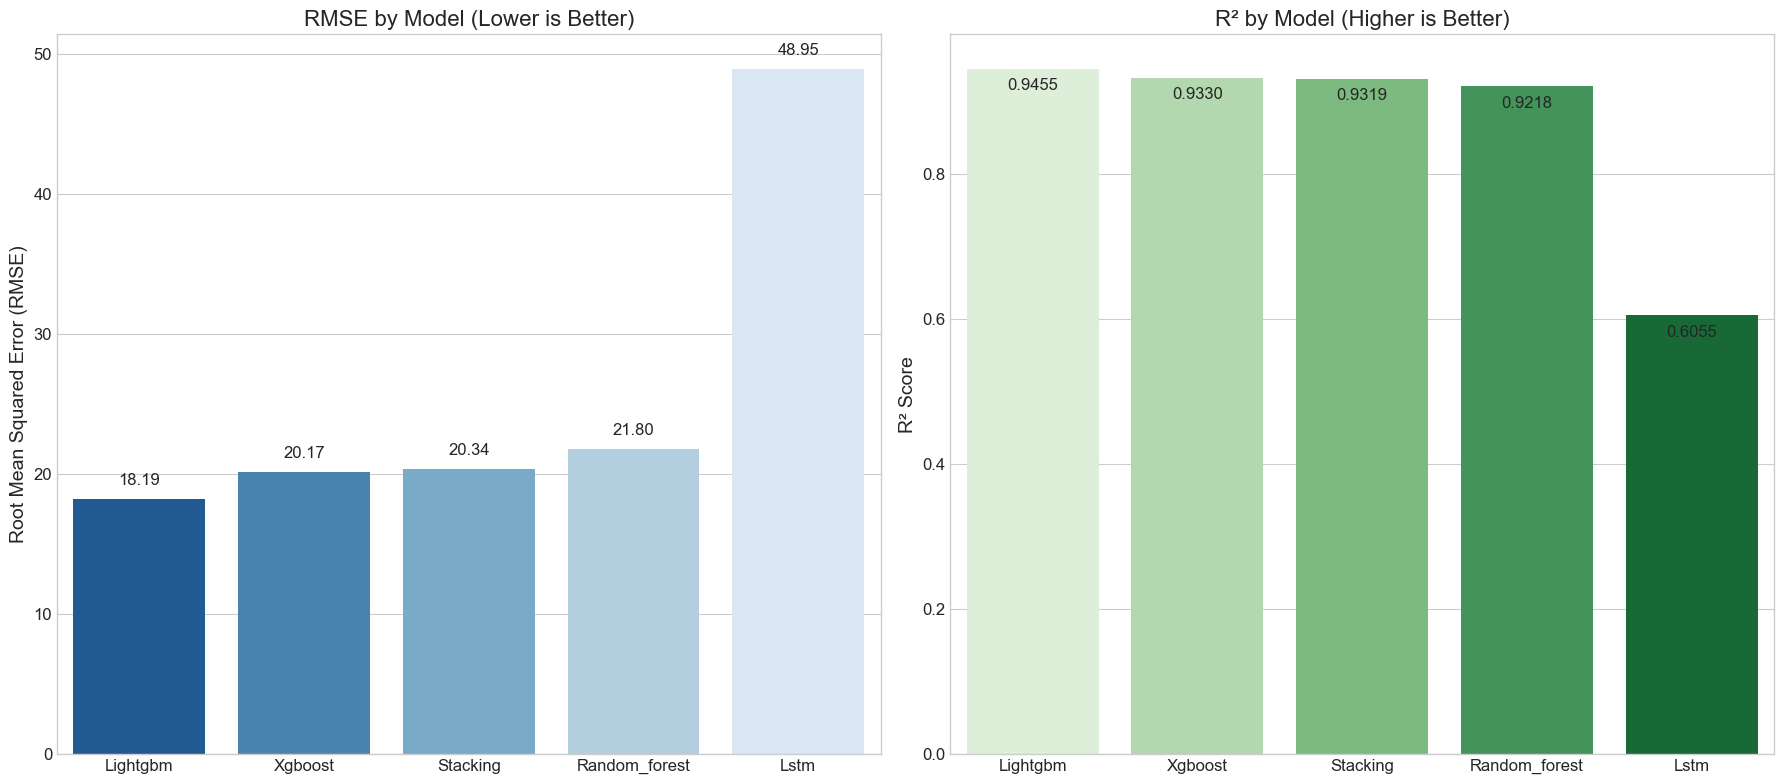

Creating prediction scatter plots...


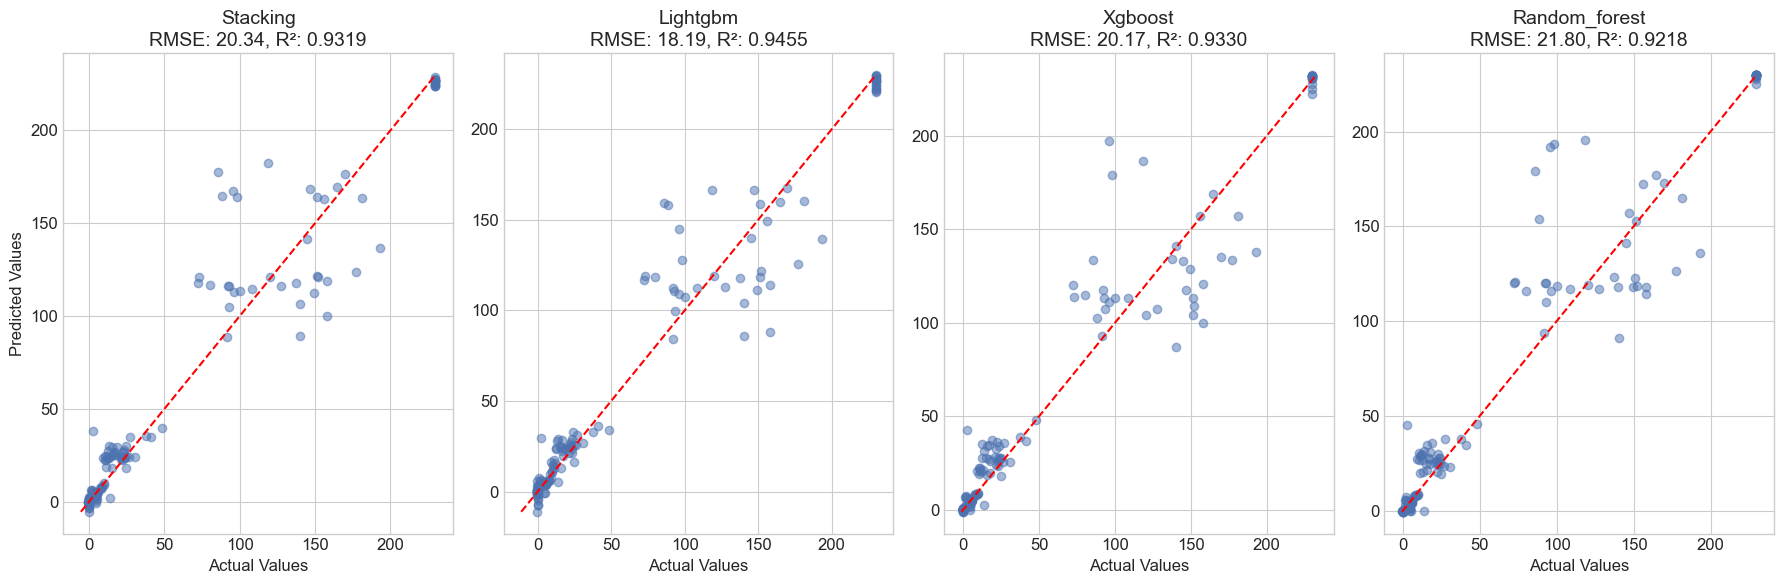

Creating residual plots...
stacking
lightgbm
xgboost
random_forest


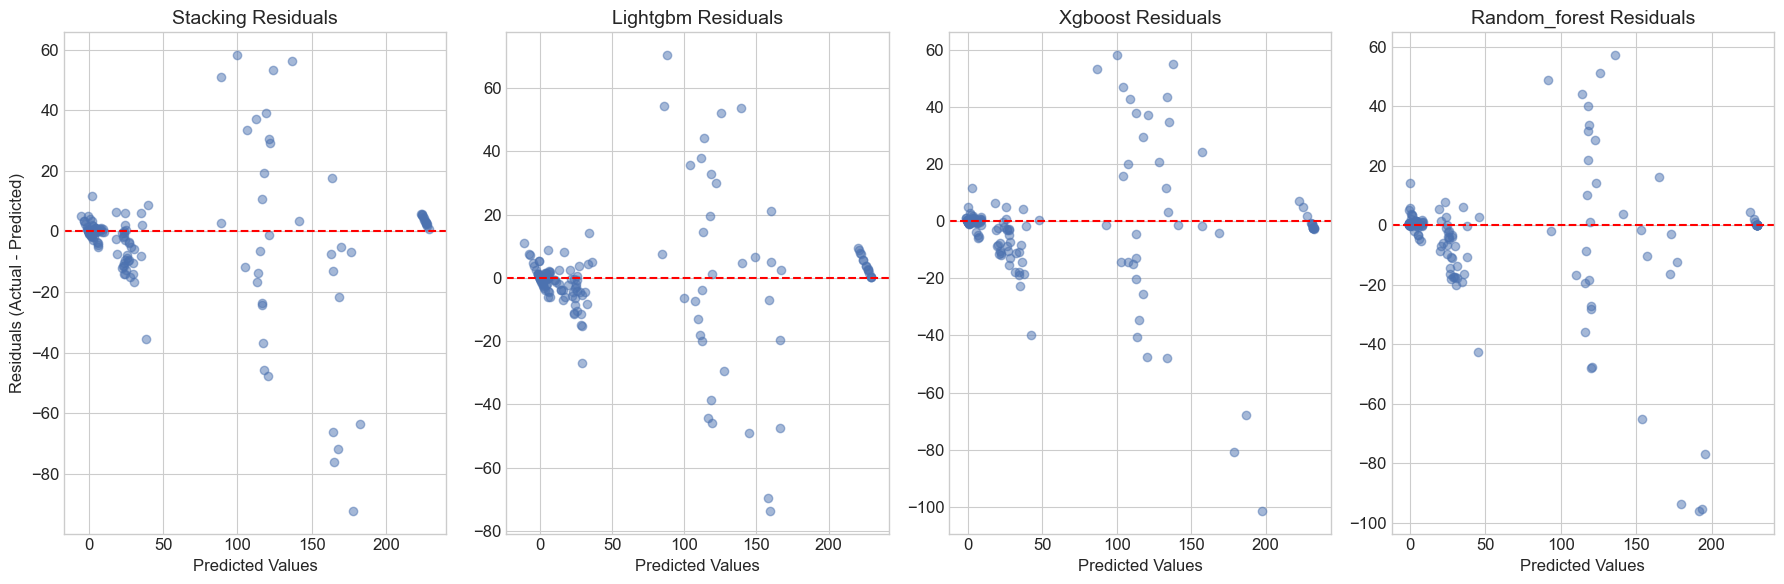

Creating model importance plot...
Stacking importance file not found!
Creating improvement chart...


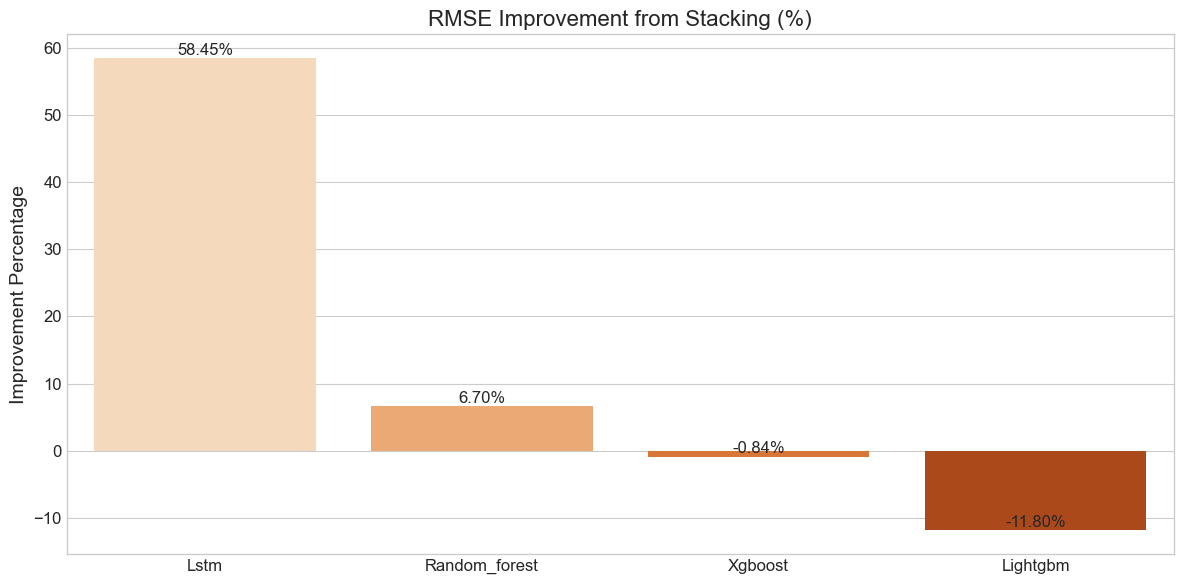

All visualizations created successfully!


In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import os
from sklearn.metrics import mean_squared_error, r2_score
import glob

# Set up plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

def load_results():
    """
    Load all prediction results and models
    """
    results = {}
    models = {}
    
    # Load stacking model if it exists
    if os.path.exists('models/stacking_model.pkl'):
        with open('models/stacking_model.pkl', 'rb') as f:
            models['stacking'] = pickle.load(f)
    
    # Load test data - using raw test data for consistent length
    if os.path.exists('models/test_data_raw.joblib'):
        X_test, y_test = joblib.load('models/test_data_raw.joblib')
    elif os.path.exists('models/test_data.joblib'):
        X_test, y_test = joblib.load('models/test_data.joblib')
    else:
        print("Test data not found!")
        return None, None, None
    
    # Load LSTM test indices if they exist
    lstm_indices = None
    if os.path.exists('models/lstm_test_indices.npy'):
        lstm_indices = np.load('models/lstm_test_indices.npy')
    
    # Find all prediction files
    for file in glob.glob('models/*_test_preds.npy'):
        model_name = os.path.basename(file).replace('_test_preds.npy', '')
        preds = np.load(file)
        
        # For LSTM, we need to align predictions with the original test data
        if model_name == 'lstm' and lstm_indices is not None:
            # Create array of the same length as y_test
            full_preds = np.zeros(len(y_test))
            # Use the indices that correspond to the LSTM predictions
            if len(preds) == len(lstm_indices):
                full_preds[lstm_indices] = preds
            elif len(preds) < len(lstm_indices):
                # If predictions are fewer than expected indices
                full_preds[lstm_indices[:len(preds)]] = preds
            else:
                # If predictions are more than expected indices
                full_preds[lstm_indices] = preds[:len(lstm_indices)]
            
            results[model_name] = full_preds
        else:
            # For non-LSTM models, just ensure the array is the right length
            if len(preds) != len(y_test):
                print(f"Warning: {model_name} predictions length ({len(preds)}) doesn't match test data ({len(y_test)})")
                if len(preds) > len(y_test):
                    results[model_name] = preds[:len(y_test)]  # Trim if too long
                else:
                    # Skip if too short
                    print(f"Skipping {model_name} as predictions are too short")
                    continue
            else:
                results[model_name] = preds
    
    # If stacking predictions exist
    if os.path.exists('models/stacking_preds.npy'):
        stacking_preds = np.load('models/stacking_preds.npy')
        # Ensure stacking predictions match the length of y_test
        if len(stacking_preds) == len(y_test):
            results['stacking'] = stacking_preds
        else:
            print(f"Warning: Stacking predictions length mismatch. Expected {len(y_test)}, got {len(stacking_preds)}")
    elif 'stacking' in models and len(results) > 0:
        # Recreate stacking predictions if we have the model and base predictions
        try:
            # Make sure all base models have same length predictions
            valid_models = {name: preds for name, preds in results.items() 
                           if name != 'stacking' and len(preds) == len(y_test)}
            
            if valid_models:
                X_meta_test = pd.DataFrame(valid_models)
                stacking_preds = models['stacking'].predict(X_meta_test)
                results['stacking'] = stacking_preds
        except Exception as e:
            print(f"Error creating stacking predictions: {e}")
    
    return results, models, y_test

def create_performance_barplot(results, y_test):
    """
    Create bar plot comparing RMSE and R² of different models
    """
    # Calculate metrics
    metrics = []
    for model_name, predictions in results.items():
        # Check if lengths match and handle the mismatch
        if len(predictions) != len(y_test):
            print(f"Warning: Length mismatch for {model_name}. Predictions: {len(predictions)}, Test data: {len(y_test)}")
            
            # Option 1: Trim the longer array to match the shorter one
            min_length = min(len(predictions), len(y_test))
            trimmed_y_test = y_test[:min_length] if isinstance(y_test, np.ndarray) else y_test.iloc[:min_length]
            trimmed_predictions = predictions[:min_length]
            
            rmse = np.sqrt(mean_squared_error(trimmed_y_test, trimmed_predictions))
            r2 = r2_score(trimmed_y_test, trimmed_predictions)
            
            print(f"  Using {min_length} samples for evaluation")
        else:
            rmse = np.sqrt(mean_squared_error(y_test, predictions))
            r2 = r2_score(y_test, predictions)
        
        metrics.append({
            'Model': model_name.capitalize(),
            'RMSE': rmse,
            'R²': r2
        })
    
    
    
    # Create dataframe
    metrics_df = pd.DataFrame(metrics)
    
    # Sort by RMSE (ascending = better)
    metrics_df = metrics_df.sort_values('RMSE')
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Plot RMSE (lower is better)
    sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=ax1, palette='Blues_r')
    ax1.set_title('RMSE by Model (Lower is Better)', fontsize=16)
    ax1.set_ylabel('Root Mean Squared Error (RMSE)', fontsize=14)
    ax1.set_xlabel('')
    for i, v in enumerate(metrics_df['RMSE']):
        ax1.text(i, v + 1, f'{v:.2f}', ha='center', fontsize=12)
    
    # Plot R² (higher is better)
    sns.barplot(x='Model', y='R²', data=metrics_df, ax=ax2, palette='Greens')
    ax2.set_title('R² by Model (Higher is Better)', fontsize=16)
    ax2.set_ylabel('R² Score', fontsize=14)
    ax2.set_xlabel('')
    for i, v in enumerate(metrics_df['R²']):
        ax2.text(i, v - 0.03, f'{v:.4f}', ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('stacking_performance_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return metrics_df

def create_prediction_scatter(results, y_test):
    """
    Create scatter plots of predicted vs actual values
    """
    # Select only a subset of models to keep the visualization clear
    if len(results) > 3:
        # Always include stacking if available
        models_to_plot = ['stacking'] if 'stacking' in results else []
        
        # Add other models based on performance
        metrics = {}
        for model_name, predictions in results.items():
            if model_name not in models_to_plot:
                rmse = np.sqrt(mean_squared_error(y_test, predictions))
                metrics[model_name] = rmse
        
        # Get the best 2-3 models
        models_to_plot.extend([k for k, v in sorted(metrics.items(), key=lambda item: item[1])[:min(3, len(metrics))]])
    else:
        models_to_plot = list(results.keys())
    
    # Create subplots
    fig, axes = plt.subplots(1, len(models_to_plot), figsize=(18, 6))
    if len(models_to_plot) == 1:
        axes = [axes]
    
    # Plot each model
    for i, model_name in enumerate(models_to_plot):
        ax = axes[i]
        predictions = results[model_name]
        
        # Create scatter plot
        ax.scatter(y_test, predictions, alpha=0.5)
        
        # Add perfect prediction line
        min_val = min(y_test.min(), predictions.min())
        max_val = max(y_test.max(), predictions.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Calculate metrics
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        r2 = r2_score(y_test, predictions)
        
        ax.set_title(f'{model_name.capitalize()}\nRMSE: {rmse:.2f}, R²: {r2:.4f}', fontsize=14)
        ax.set_xlabel('Actual Values', fontsize=12)
        if i == 0:
            ax.set_ylabel('Predicted Values', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('prediction_scatter_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_residual_plots(results, y_test):
    """
    Create residual plots for models
    """
    # Select only a subset of models to keep the visualization clear
    if len(results) > 3:
        # Always include stacking if available
        models_to_plot = ['stacking'] if 'stacking' in results else []
        
        # Add other models based on performance
        metrics = {}
        for model_name, predictions in results.items():
            if model_name not in models_to_plot:
                rmse = np.sqrt(mean_squared_error(y_test, predictions))
                metrics[model_name] = rmse
        
        # Get the best 2-3 models
        models_to_plot.extend([k for k, v in sorted(metrics.items(), key=lambda item: item[1])[:min(3, len(metrics))]])
    else:
        models_to_plot = list(results.keys())
    
    # Create subplots
    fig, axes = plt.subplots(1, len(models_to_plot), figsize=(18, 6))
    if len(models_to_plot) == 1:
        axes = [axes]
    
    # Plot each model
    for i, model_name in enumerate(models_to_plot):
        ax = axes[i]
        predictions = results[model_name]
        predictions = predictions.flatten()
        y_test = y_test.flatten()
        print(model_name)
        # Calculate residuals
        residuals = y_test - predictions
        # Create scatter plot
        ax.scatter(predictions.flatten(), residuals.flatten(), alpha=0.5)
        ax.axhline(y=0, color='r', linestyle='--')
        
        ax.set_title(f'{model_name.capitalize()} Residuals', fontsize=14)
        ax.set_xlabel('Predicted Values', fontsize=12)
        if i == 0:
            ax.set_ylabel('Residuals (Actual - Predicted)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('residual_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

def create_model_importance_plot():
    """
    Create plot showing importance of each model in the stacking
    """
    # Check if stacking importance file exists
    if os.path.exists('models/stacking_importance.csv'):
        importance_df = pd.read_csv('models/stacking_importance.csv')
        
        # Sort by importance
        importance_df = importance_df.sort_values('Importance', ascending=False)
        
        plt.figure(figsize=(12, 6))
        ax = sns.barplot(x='Model', y='Importance', data=importance_df, palette='viridis')
        
        plt.title('Model Importance in Stacking', fontsize=16)
        plt.ylabel('Importance Score', fontsize=14)
        plt.xlabel('')
        
        # Add importance values on top of bars
        for i, v in enumerate(importance_df['Importance']):
            ax.text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=12)
        
        plt.tight_layout()
        plt.savefig('model_importance_in_stacking.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return importance_df
    else:
        print("Stacking importance file not found!")
        return None

def create_improvement_chart(metrics_df):
    """
    Create a chart showing improvement from stacking
    """
    if 'Stacking' not in metrics_df['Model'].values:
        print("Stacking results not found in metrics!")
        return
    
    # Get stacking RMSE
    stacking_rmse = metrics_df.loc[metrics_df['Model'] == 'Stacking', 'RMSE'].values[0]
    
    # Get other models' RMSE
    other_models = metrics_df[metrics_df['Model'] != 'Stacking']
    
    # Calculate improvement percentage
    improvement_df = pd.DataFrame({
        'Model': other_models['Model'],
        'RMSE': other_models['RMSE'],
        'Improvement (%)': ((other_models['RMSE'] - stacking_rmse) / other_models['RMSE'] * 100)
    })
    
    # Sort by improvement (descending)
    improvement_df = improvement_df.sort_values('Improvement (%)', ascending=False)
    
    # Create bar chart
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='Model', y='Improvement (%)', data=improvement_df, palette='Oranges')
    
    plt.title('RMSE Improvement from Stacking (%)', fontsize=16)
    plt.ylabel('Improvement Percentage', fontsize=14)
    plt.xlabel('')
    
    # Add values on top of bars
    for i, v in enumerate(improvement_df['Improvement (%)']):
        ax.text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=12)
    
    plt.tight_layout()
    plt.savefig('stacking_improvement.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return improvement_df

def main():
    """
    Main function to create all visualizations
    """
    results, models, y_test = load_results()
    
    if results is None:
        print("Failed to load results!")
        return
    
    print("Creating performance comparison plot...")
    metrics_df = create_performance_barplot(results, y_test)
    
    print("Creating prediction scatter plots...")
    create_prediction_scatter(results, y_test)
    
    print("Creating residual plots...")
    create_residual_plots(results, y_test)
    
    print("Creating model importance plot...")
    importance_df = create_model_importance_plot()
    
    print("Creating improvement chart...")
    improvement_df = create_improvement_chart(metrics_df)
    
    print("All visualizations created successfully!")

if __name__ == "__main__":
    main()